In [ ]:
#import lib
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#libraries for RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# libraries for RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score

#libraries for Elastic Net
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet

# libraries to plot Venn diagram
from matplotlib_venn import venn3

In [ ]:
#import dataset
github_raw_url = 'https://raw.githubusercontent.com/mohandaz/HIA-303-Project/main/wdbc.data'

# Fetch data from the URL
response = requests.get(github_raw_url)

if response.status_code == 200:
    # Load breast cancer data from CSV file using Pandas
    bca = pd.read_csv(StringIO(response.text), header=None)
else:
    print(f"Failed to fetch data. Status Code: {response.status_code}")

In [ ]:
#prepare dataframe

# Rename columns
column_names = [
    'ID', 'Diagnosis',
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
    'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
    'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst',
    'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

bca.columns = column_names
bca.head(20)

# Move the 'Diagnosis' column to the last
diagnosis_column = bca.pop('Diagnosis')
bca['Diagnosis'] = diagnosis_column

# Add a new column 'unique ID' with unique values
bca.insert(0, 'PID', range(1, len(bca) + 1))

# Remove the 'Patient ID' column
bca.drop('ID', axis=1, inplace=True)
bca.head(20)

,PID,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890,M
1,2,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902,M
2,3,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.24300,0.3613,0.08758,M
3,4,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.25750,0.6638,0.17300,M
4,5,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.16250,0.2364,0.07678,M
5,6,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440,M
6,7,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,M
7,8,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510,M
8,9,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720,M
9,10,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.22100,0.4366,0.20750,M


Empty DataFrame
Columns: [PID, radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave_points_mean, symmetry_mean, fractal_dimension_mean, radius_se, texture_se, perimeter_se, area_se, smoothness_se, compactness_se, concavity_se, concave_points_se, symmetry_se, fractal_dimension_se, radius_worst, texture_worst, perimeter_worst, area_worst, smoothness_worst, compactness_worst, concavity_worst, concave_points_worst, symmetry_worst, fractal_dimension_worst, Diagnosis]
Index: []

[0 rows x 32 columns]
Kolmogorov–Smirnov test for radius_mean: p-value = 0.0
Kolmogorov–Smirnov test for texture_mean: p-value = 0.0
Kolmogorov–Smirnov test for perimeter_mean: p-value = 0.0
Kolmogorov–Smirnov test for area_mean: p-value = 0.0
Kolmogorov–Smirnov test for smoothness_mean: p-value = 1.5963292620766572e-145
Kolmogorov–Smirnov test for compactness_mean: p-value = 1.824153479421873e-136
Kolmogorov–Smirnov test for concavity_mean: p-value = 4.6044

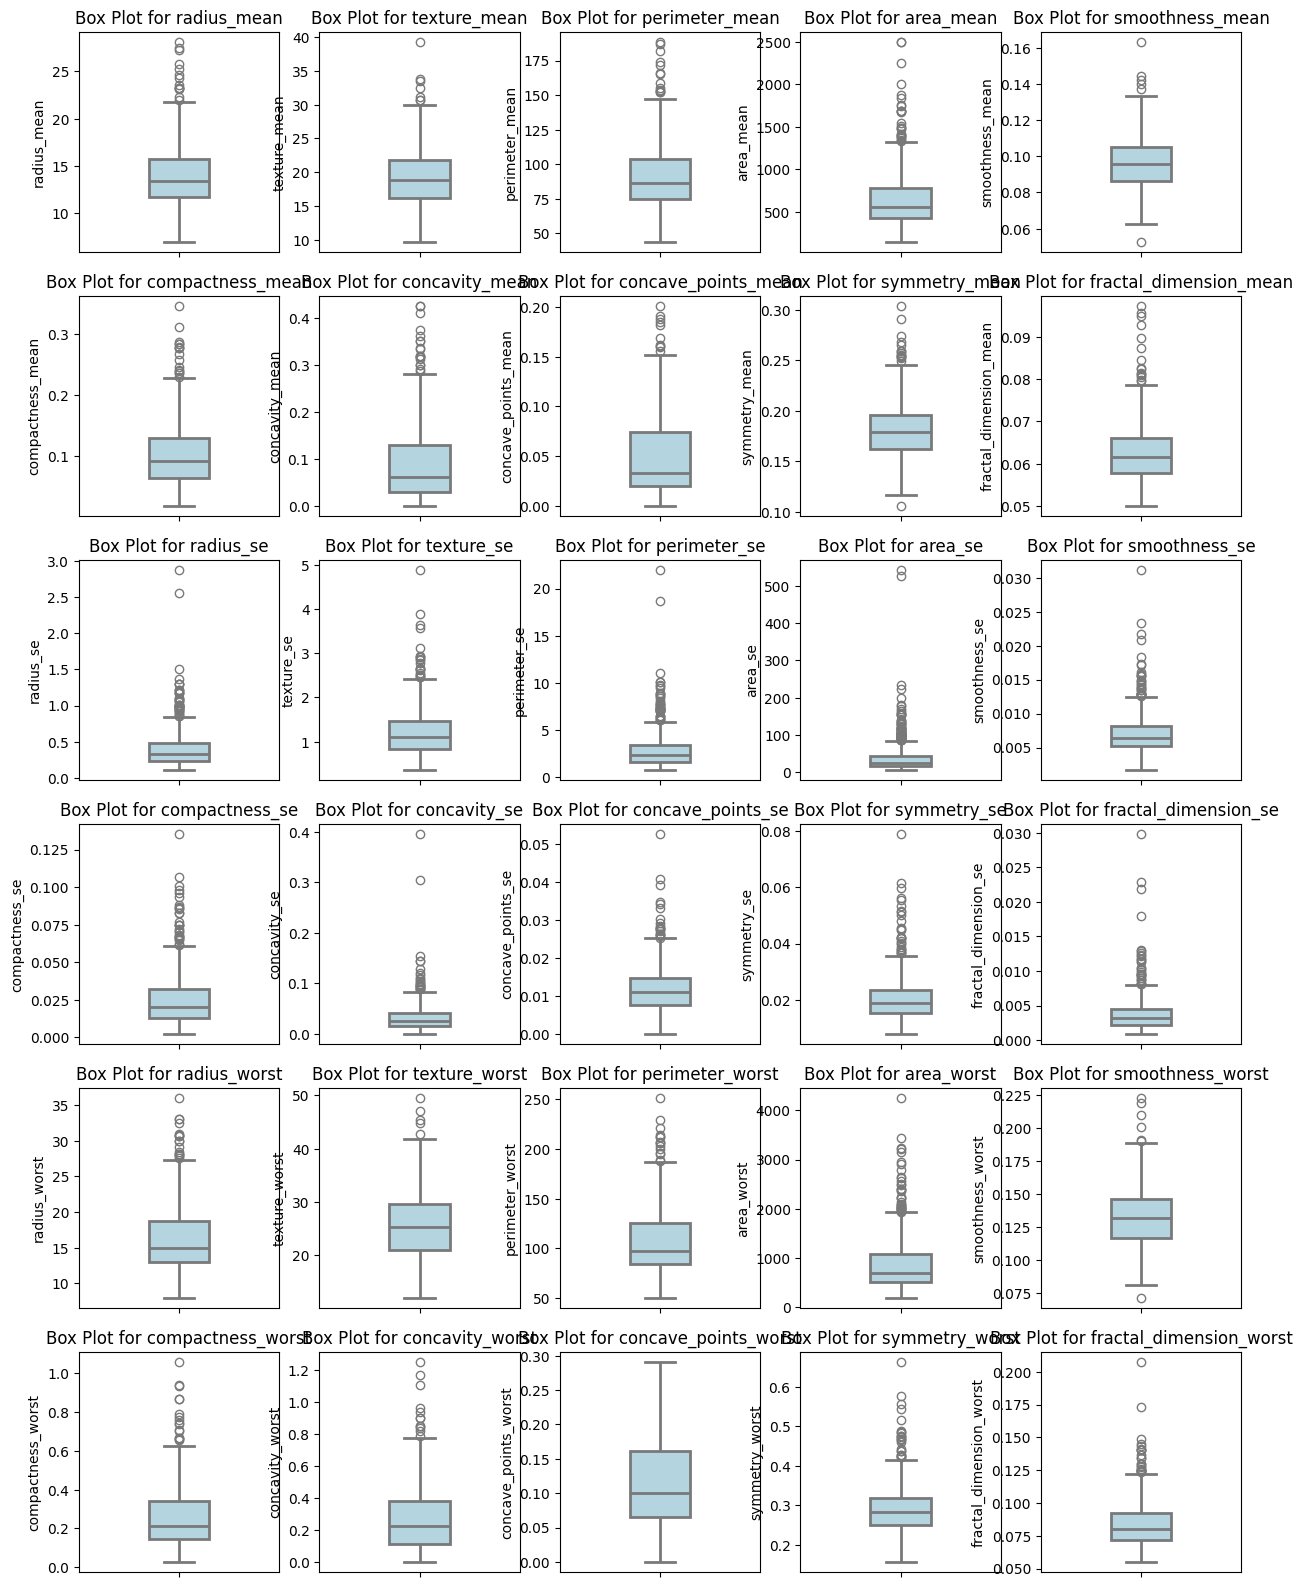

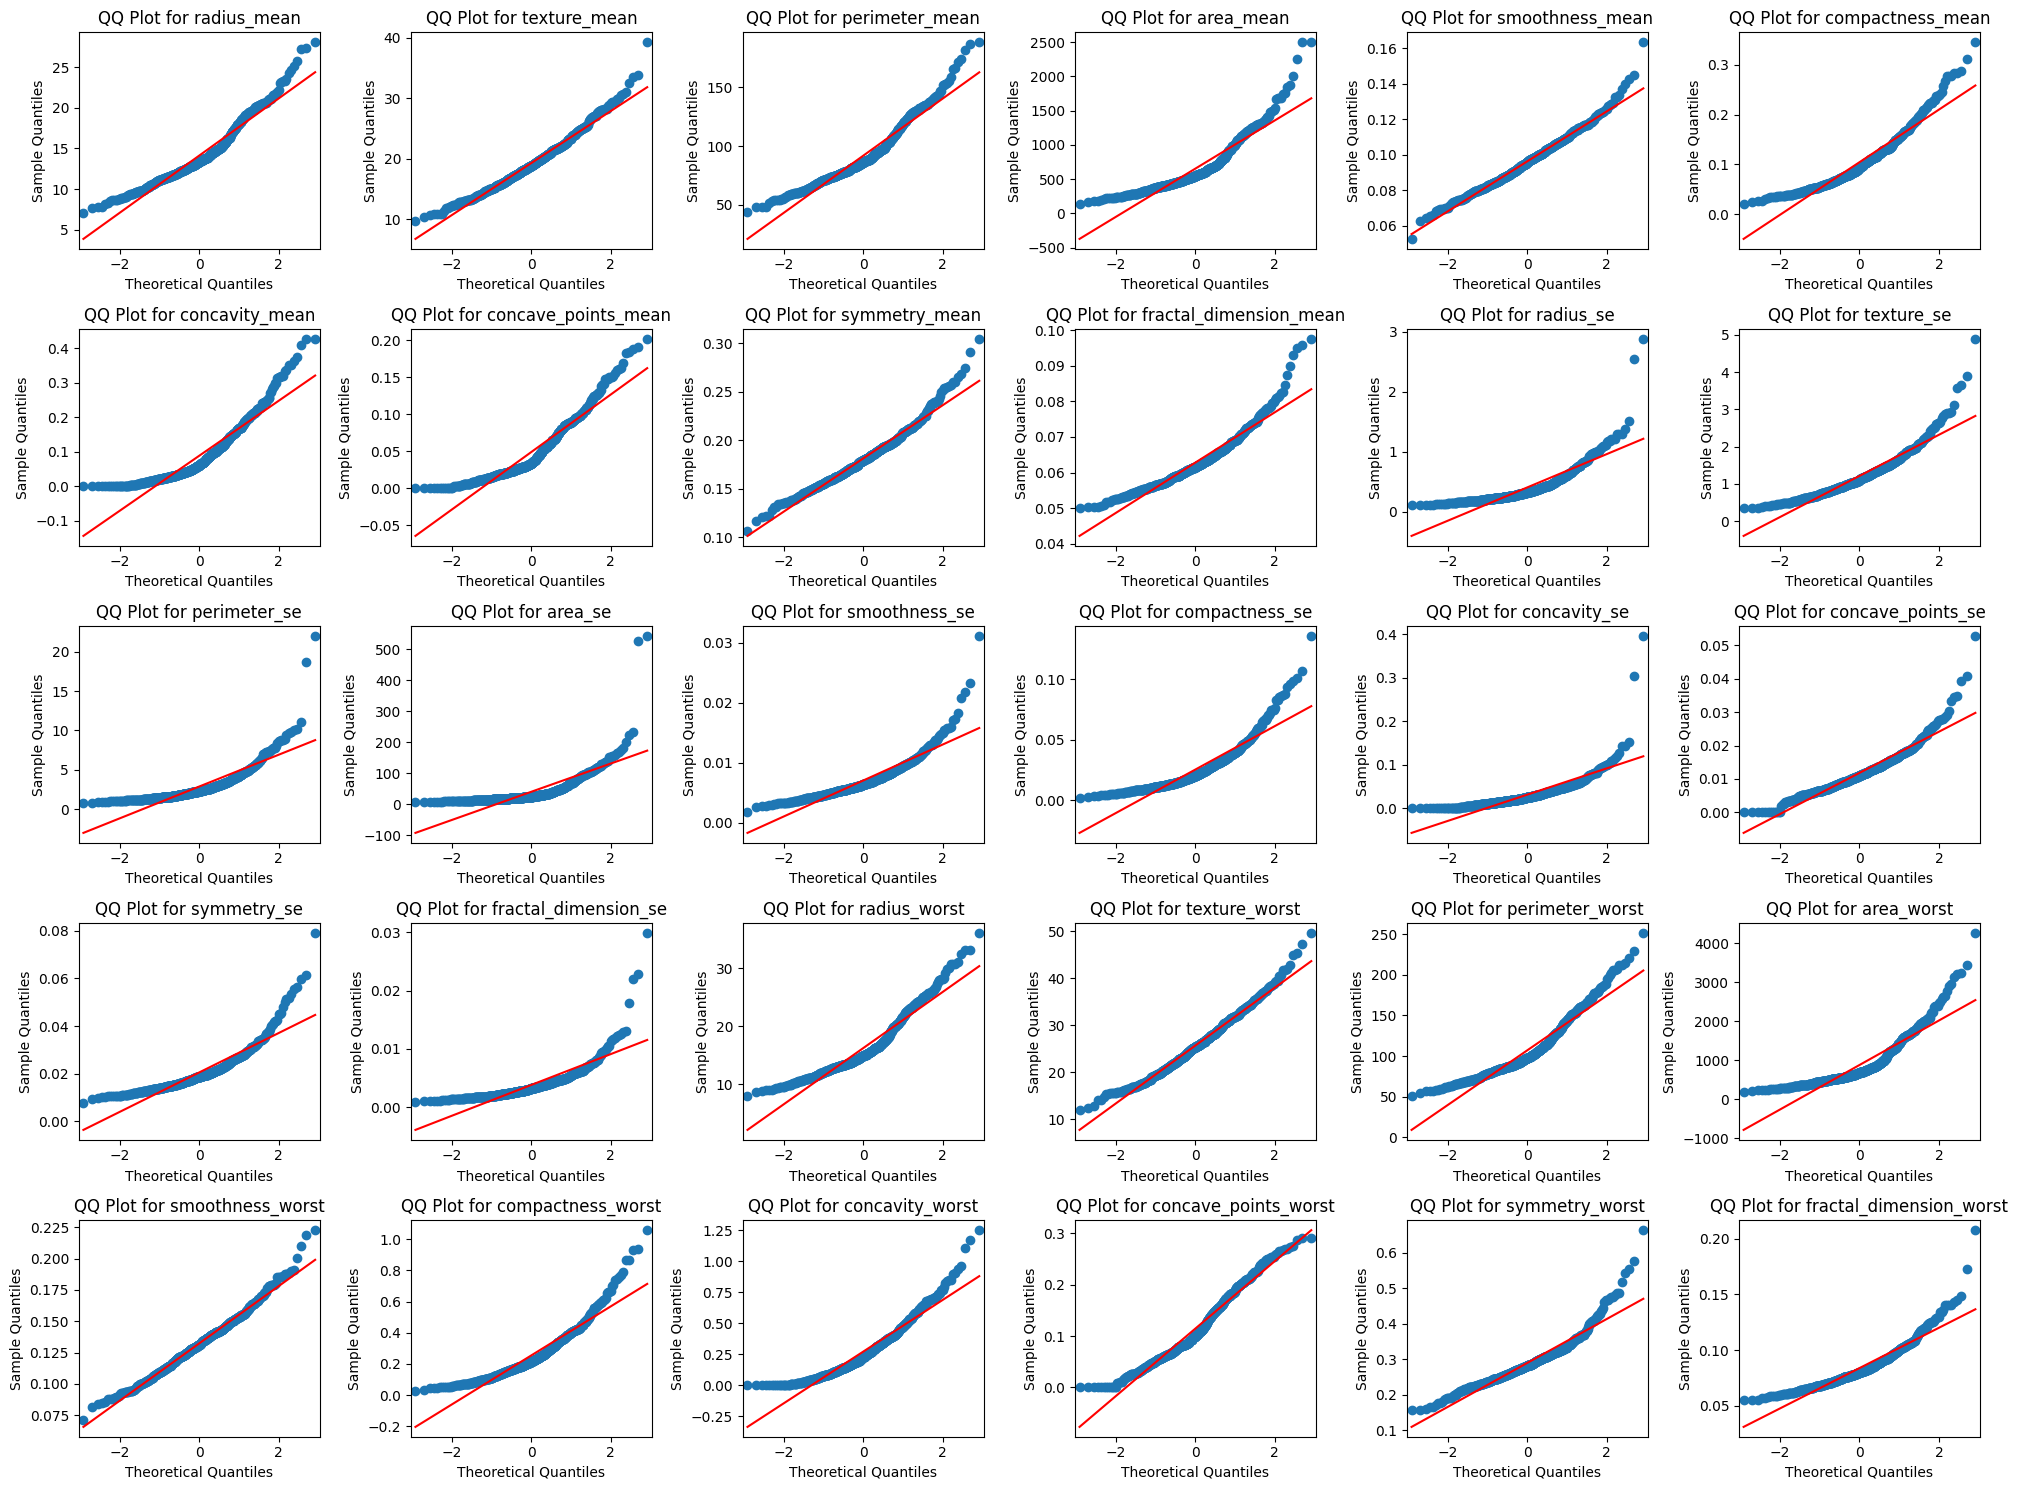

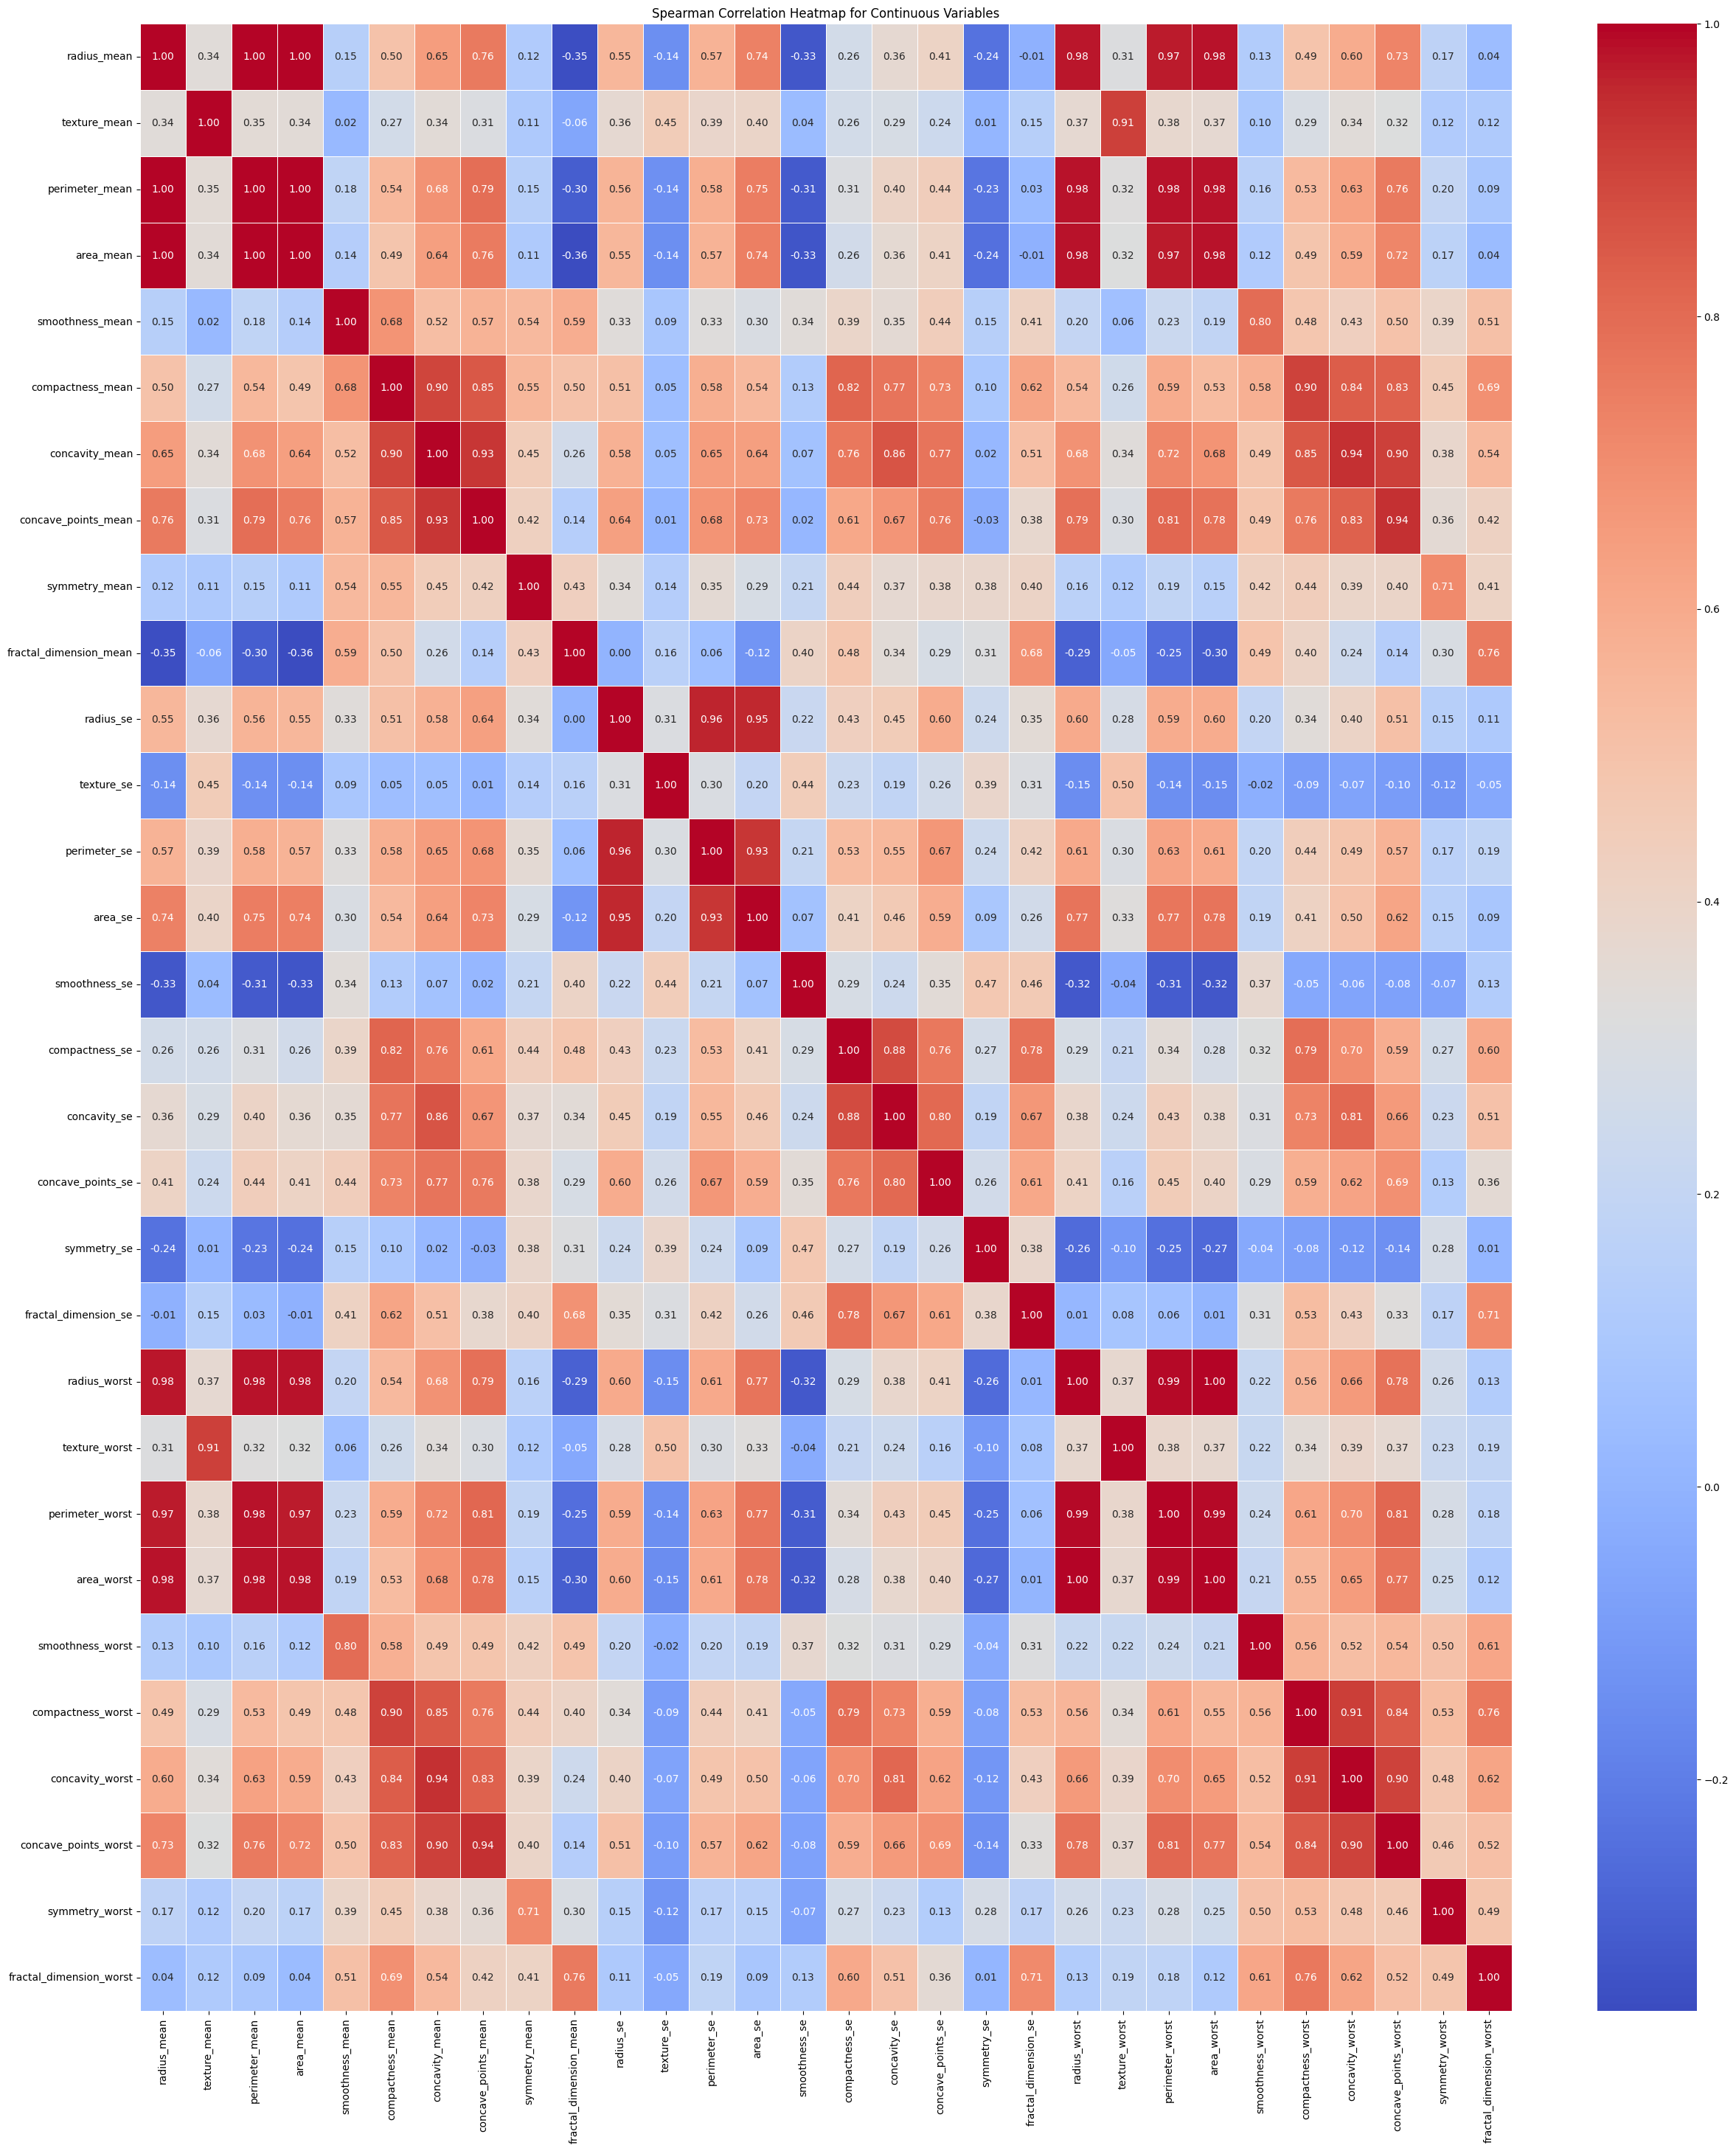

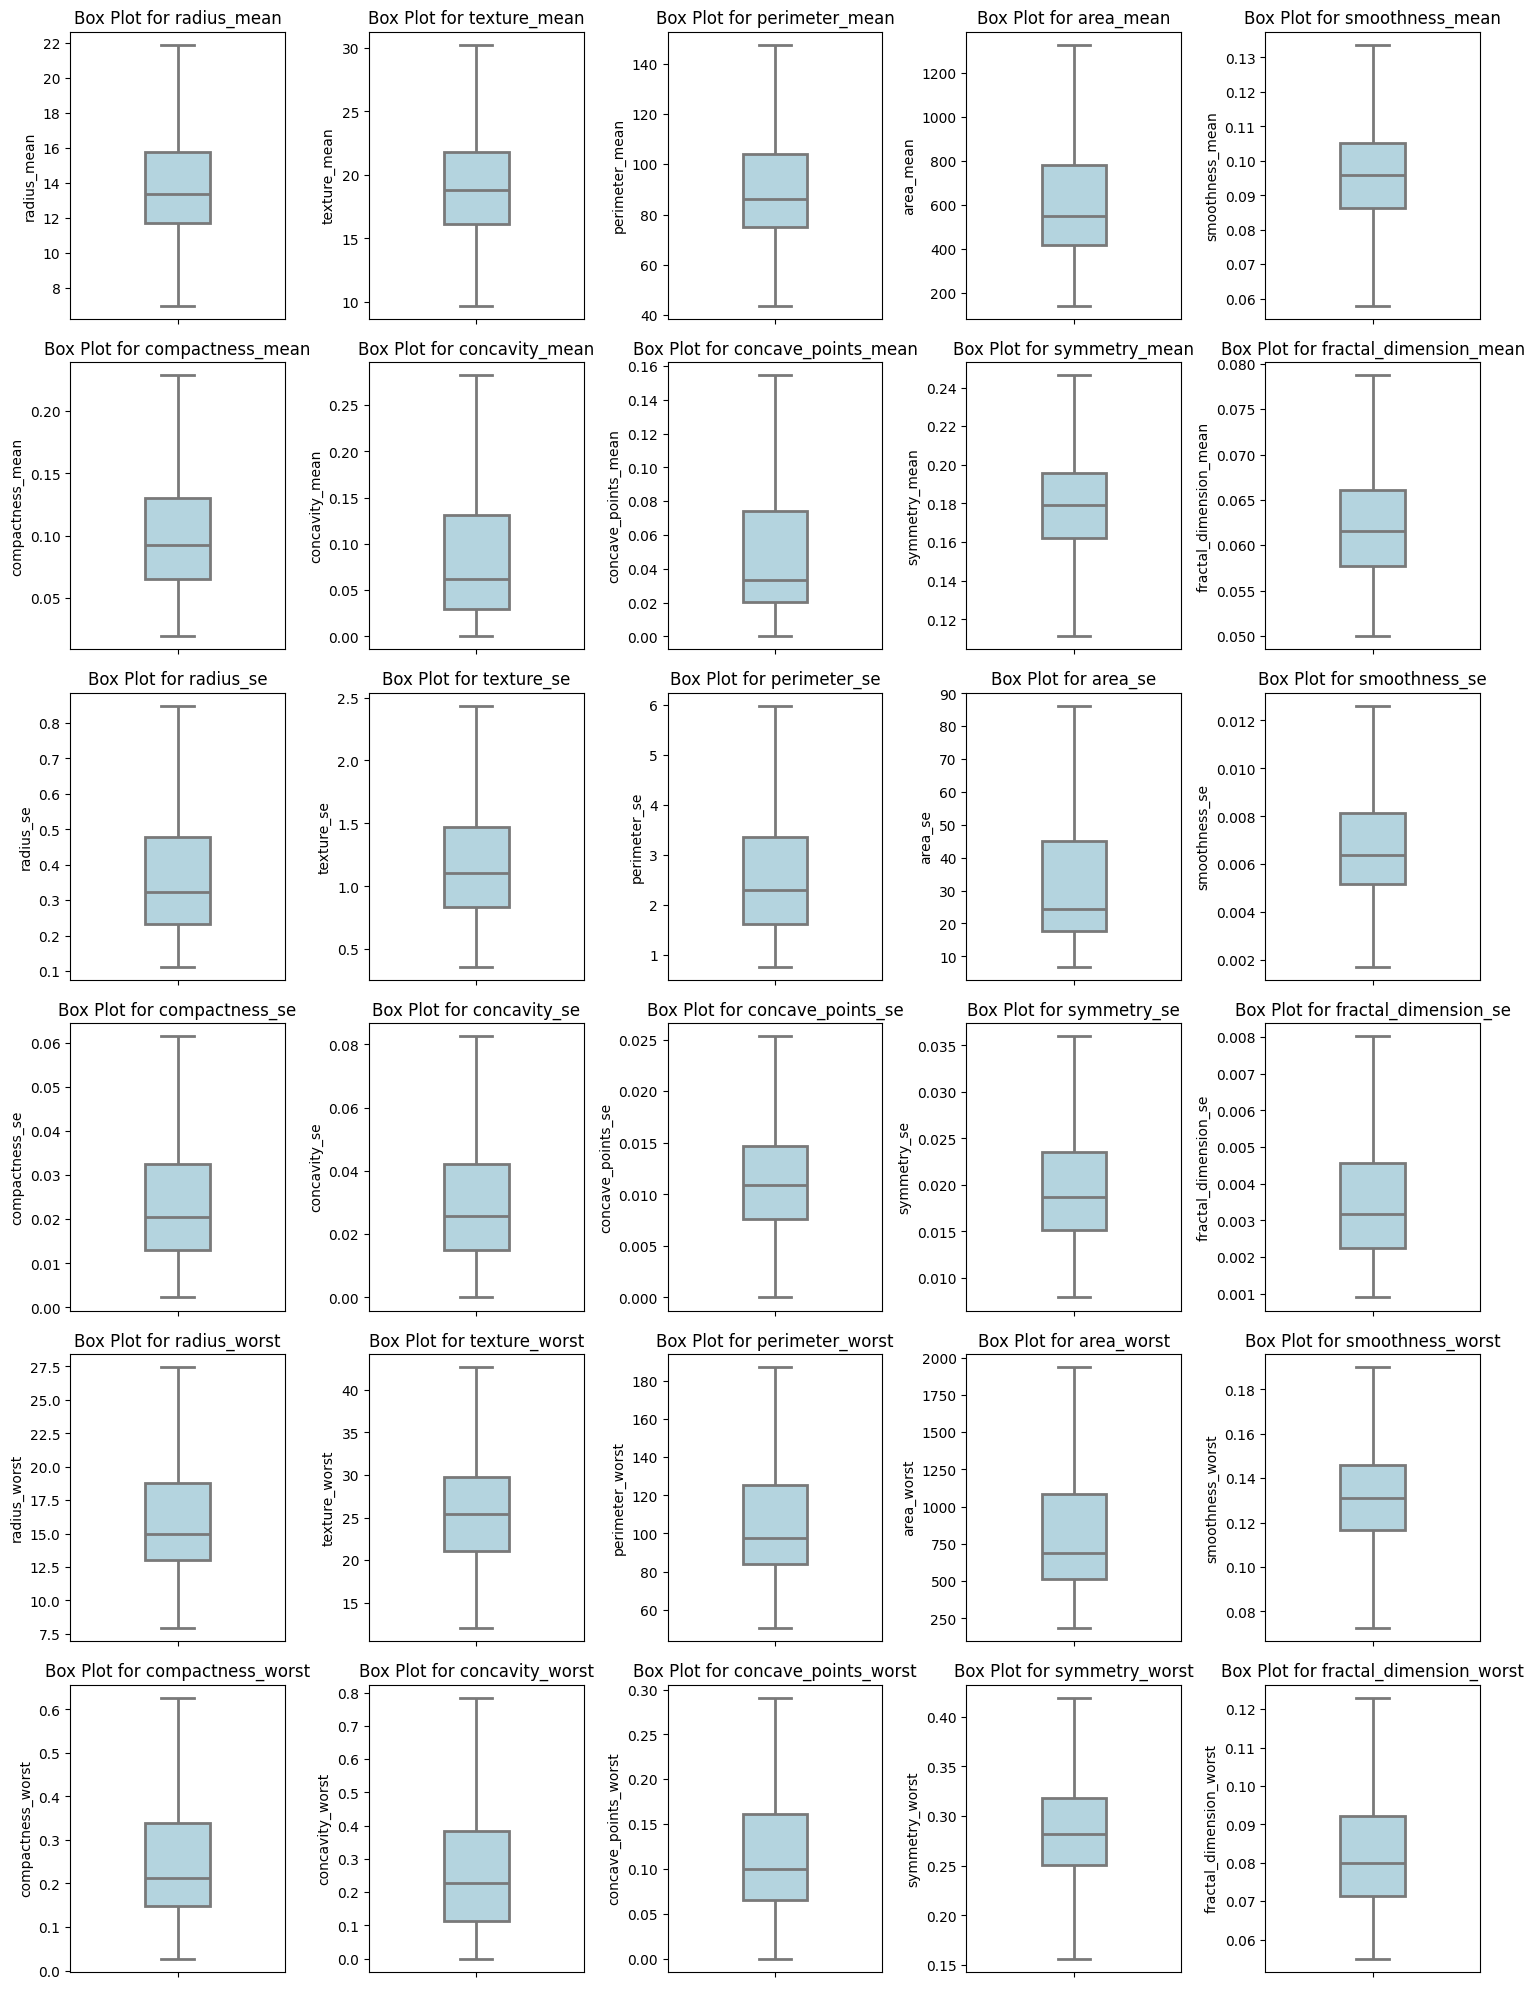

PID                        0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
Diagnosis                  0
dtype: int64


In [ ]:
# Data Preprocessing
# Check for duplicate rows
duplicate_rows = bca[bca.duplicated()]
print(duplicate_rows)

# OUTLIERS
# Selecting all continuous variables for outlier detection
continuous_columns = bca.columns[1:31]

# Create individual horizontal box plots for each continuous variable
plt.figure(figsize=(15, 20))
for i, column in enumerate(continuous_columns, 1):
    plt.subplot(6, 5, i)
    sns.boxplot(y=bca[column], width=0.3, color='lightblue', linewidth=2)
    plt.title(f'Box Plot for {column}')

outlier_threshold = 1.5
# Calculate the percentage of outliers for each column
outliers_percentage = ((bca[continuous_columns] < bca[continuous_columns].quantile(0.25) - outlier_threshold * (bca[continuous_columns].quantile(0.75) - bca[continuous_columns].quantile(0.25))) |
                       (bca[continuous_columns] > bca[continuous_columns].quantile(0.75) + outlier_threshold * (bca[continuous_columns].quantile(0.75) - bca[continuous_columns].quantile(0.25)))).mean() * 100

# Calculate statistics for each continuous variable
statistics = []

for column in continuous_columns:
    q1 = bca[column].quantile(0.25)
    q3 = bca[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr

    min_value = bca[column].min()
    max_value = bca[column].max()

    statistics.append({
        'Variable': column,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Minimum Value': min_value,
        'Maximum Value': max_value
    })

# Create a DataFrame from the list of dictionaries
statistics_df = pd.DataFrame(statistics)


# OUTLIERS CORRECTION
# Create a copy of the original DataFrame
bca_capped = bca.copy()
start_column = 1
end_column = 31

# Iterate over each variable in columns start_column to end_column
for column in bca_capped.columns[start_column:end_column + 1]:
    # Check if the column contains numeric data
    if pd.api.types.is_numeric_dtype(bca_capped[column]):
        q1 = bca[column].quantile(0.25)
        q3 = bca[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr

        # Cap values above the upper bound to the upper bound value
        bca_capped[column] = np.clip(bca_capped[column], lower_bound, upper_bound)

# Check normality using Kolmogorov–Smirnov test and QQ plot
for column in continuous_columns:
    # Kolmogorov–Smirnov test
    kstest_result = kstest(bca[column], 'norm')
    p_value_formatted = "{:.3f}".format(kstest_result.pvalue)
    print(f'Kolmogorov–Smirnov test for {column}: p-value = {kstest_result.pvalue}')

# Combine QQ plots into subplots
num_plots = len(continuous_columns)
num_cols = 6
num_rows = 5

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 15))

for i, column in enumerate(continuous_columns):
    row = i // num_cols
    col = i % num_cols

    # QQ plot
    sm.qqplot(bca[column], line='s', ax=axes[row, col])
    axes[row, col].set_title(f'QQ Plot for {column}')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

# Calculate the Spearman correlation matrix
correlation_matrix = bca[continuous_columns].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(30, 35))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Spearman Correlation Heatmap for Continuous Variables')
plt.show()

# Create individual box plots for each continuous variable in the corrected DataFrame

plt.figure(figsize=(15, 20))
for i, column in enumerate(continuous_columns, 1):
    plt.subplot(6, 5, i)
    sns.boxplot(y=bca_capped[column], width=0.3, color='lightblue', linewidth=2)
    plt.title(f'Box Plot for {column}')

plt.tight_layout()
plt.show()

# Missing values
# Check for missing values
missing_values = bca.isnull().sum()
print(missing_values)

,PID,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
0,1,1.176800,-2.121200,1.357375,1.184085,1.618861,2.541404,2.647422,2.620973,2.348535,...,-1.375159,2.439568,2.287627,1.344848,2.641905,2.246192,2.296076,2.443918,2.225247,M
1,2,1.949929,-0.354875,1.795991,2.249396,-0.842995,-0.498189,-0.000497,0.574944,0.017882,...,-0.370048,1.631542,2.287627,-0.377098,-0.443388,-0.137634,1.087084,-0.234408,0.355314,M
2,3,1.686226,0.476899,1.670052,1.846217,0.975239,1.148680,1.496076,2.110330,1.004666,...,-0.019582,1.434234,1.807751,0.546654,1.223448,0.920718,1.955000,1.369057,0.265197,M
3,4,-0.791983,0.268955,-0.606410,-0.831485,2.737521,2.541404,2.091997,1.506601,2.521318,...,0.140773,-0.245395,-0.593838,2.595949,2.641905,2.119474,2.175786,2.443918,2.482456,M
4,5,1.866023,-1.174698,1.891531,2.154338,0.295047,0.599453,1.504202,1.482665,0.006363,...,-1.484267,1.424838,1.525780,0.232758,-0.314469,0.665254,0.729259,-0.951602,-0.410683,M
5,6,-0.483330,-0.849637,-0.389708,-0.533197,2.306367,1.353373,0.959747,0.860053,1.073779,...,-0.313842,-0.103520,-0.227908,2.102683,1.926896,1.352067,0.905888,2.060238,2.482456,M
6,7,1.254712,0.173349,1.218407,1.311922,-0.119651,0.117107,0.348929,0.676807,-0.051231,...,0.332537,1.456157,1.591012,0.537686,0.054070,0.555769,1.196716,0.347150,0.021129,M
7,8,-0.105756,0.376512,-0.058357,-0.202787,1.655431,1.241906,0.091058,0.300474,1.492298,...,0.411888,0.121975,0.099094,1.488343,0.828984,-0.004833,0.624196,0.594266,1.987437,M
8,9,-0.318516,0.613138,-0.175611,-0.393232,2.269798,1.823560,1.340324,1.196226,2.083601,...,0.840052,-0.015828,-0.232747,1.708070,2.033394,1.369808,1.391616,2.443918,1.493044,M
9,10,-0.480334,1.143752,-0.328910,-0.537131,1.633489,2.541404,1.901031,0.980799,0.854921,...,2.484930,-0.283603,-0.291456,2.380705,2.641905,2.619251,1.620015,2.443918,2.482456,M


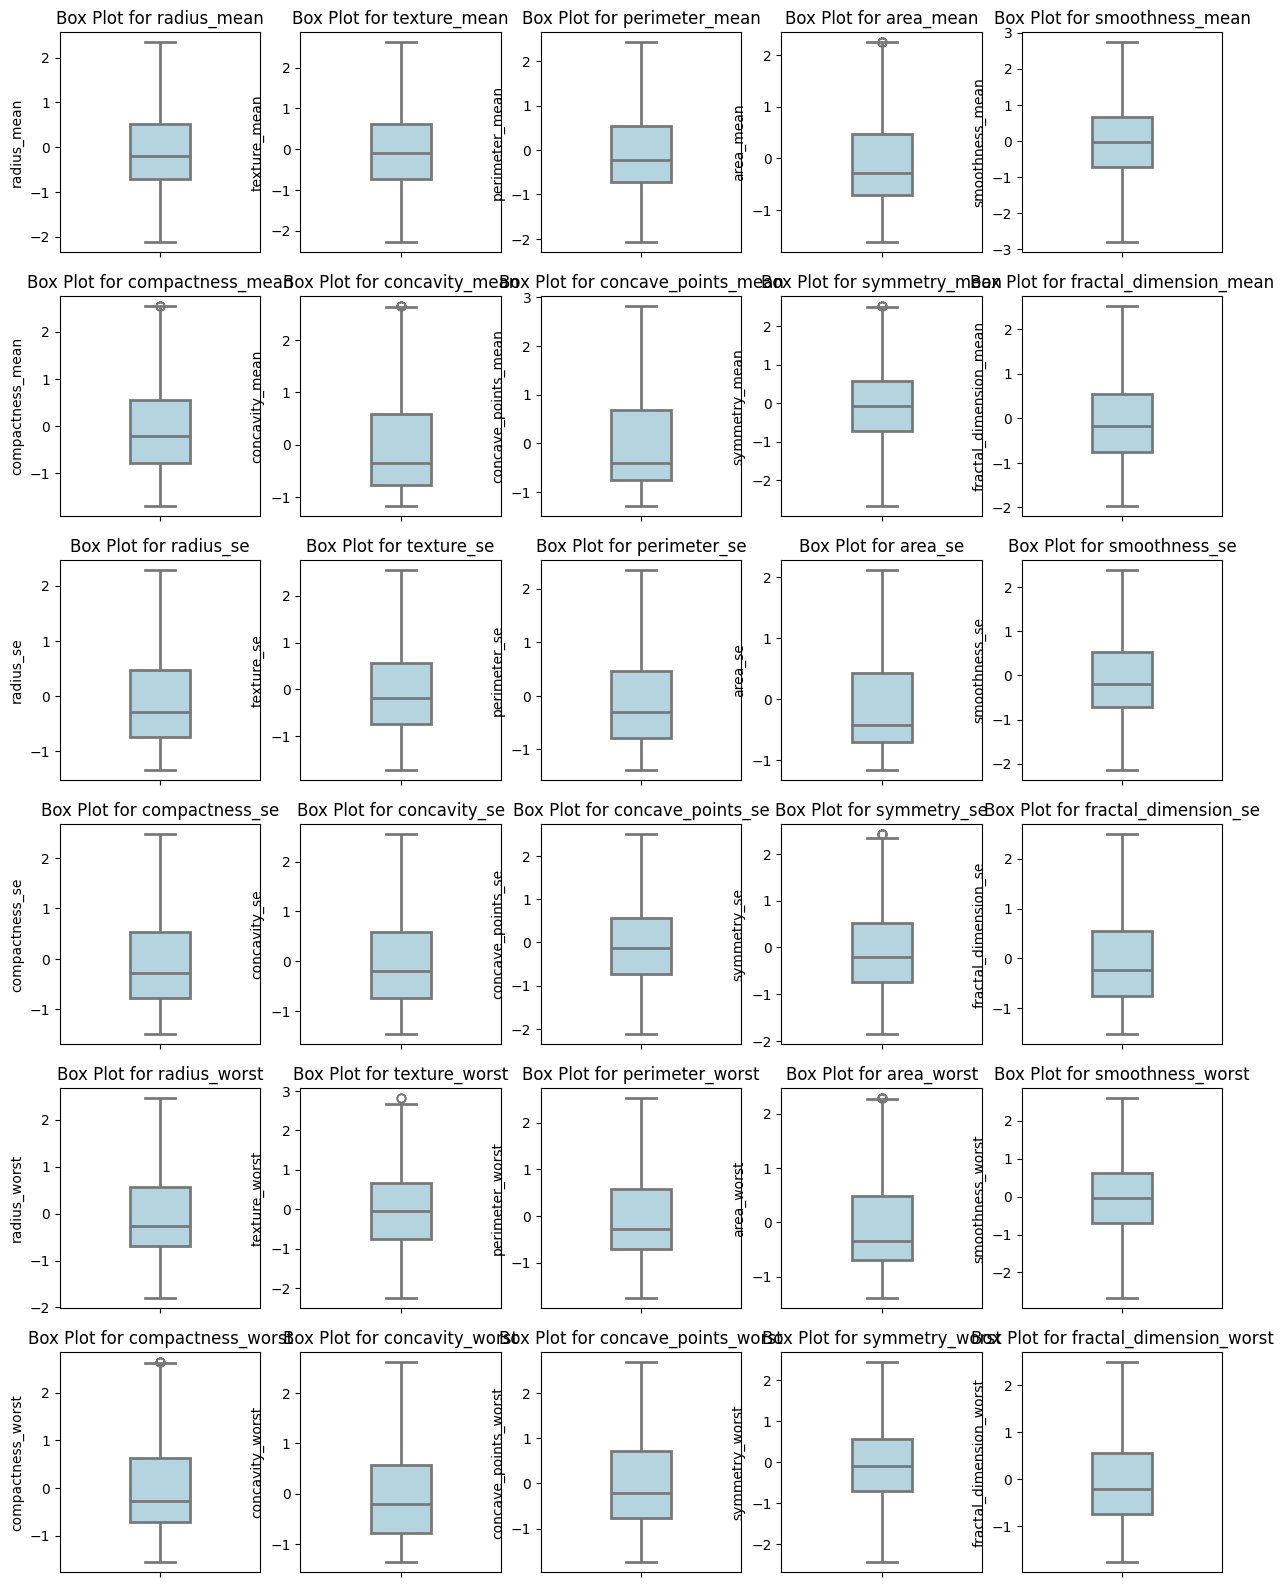

In [ ]:
# Data Scaling
# Create a copy of the DataFrame for feature scaling
bca_capped_scaled = bca_capped.copy()

# Select only the numeric columns for feature scaling
numeric_columns = bca_capped_scaled.select_dtypes(include='number').columns

# Instantiate StandardScaler
scaler = StandardScaler()

# Perform feature scaling on selected columns
bca_capped_scaled[continuous_columns] = scaler.fit_transform(bca_capped_scaled[continuous_columns])


# Create individual box plots for each continuous variable in the scaled DataFrame

plt.figure(figsize=(15, 20))
for i, column in enumerate(continuous_columns, 1):
    plt.subplot(6, 5, i)
    sns.boxplot(y=bca_capped_scaled[column], width=0.3, color='lightblue', linewidth=2)
    plt.title(f'Box Plot for {column}')

bca_capped_scaled.head(20)

Class distribution before oversampling:
B    357
M    212
Name: Diagnosis, dtype: int64
Class distribution after oversampling:
M    357
B    357
Name: Diagnosis, dtype: int64


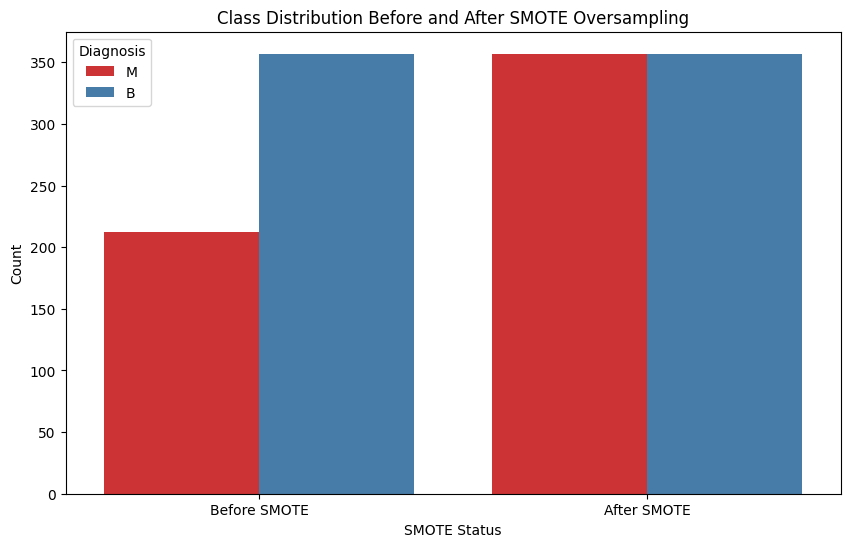

In [ ]:
# oversampling
#SMOTE
# Separate features and target variable
X = bca_capped_scaled.drop('Diagnosis', axis=1)
y = bca_capped_scaled['Diagnosis']

# SMOTE
smote = SMOTE(random_state=43)

# Fit and apply SMOTE on the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine the resampled data into a new DataFrame
bca_capped_scaled_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='Diagnosis')], axis=1)

# Display the class distribution after oversampling
print("Class distribution before oversampling:")
print(bca_capped_scaled['Diagnosis'].value_counts())

print("Class distribution after oversampling:")
print(bca_capped_scaled_balanced['Diagnosis'].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(x='Source', data=pd.concat([bca_capped_scaled.assign(Source='Before SMOTE'), bca_capped_scaled_balanced.assign(Source='After SMOTE')]),
              hue='Diagnosis', palette='Set1')
plt.title('Class Distribution Before and After SMOTE Oversampling')
plt.xlabel('SMOTE Status')
plt.ylabel('Count')
plt.legend(title='Diagnosis')
plt.show()

In [ ]:
#prepare % partition training % testing data
# Create a copy of the DataFrame for mapping and modification
bca_processed = bca_capped_scaled_balanced.copy()

# Map 'M' to 1 and 'B' to 0 in the 'Diagnosis' column
bca_processed['Diagnosis'] = bca_processed['Diagnosis'].map({'M': 1, 'B': 0})

# Create a new column 'dx' with 1 for 'M' and 0 for 'B'
bca_processed['Malignant'] = (bca_processed['Diagnosis'] == 1).astype(int)

# Drop the original 'Diagnosis' column
bca_processed = bca_processed.drop('Diagnosis', axis=1)


"""SPLITTING DATA"""
# Perform train-test split (80:20) using bca_balanced_2
X_train, X_test, y_train, y_test = train_test_split(bca_processed.drop('Malignant', axis=1),
                                                    bca_processed['Malignant'],
                                                    test_size=0.2,
                                                    random_state=43)

# Create DataFrames for training and testing sets
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.head(20)



,PID,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Malignant
63,64,-1.465324,-1.289426,-1.404605,-1.241875,-1.393731,-0.318423,-0.366447,-0.711503,2.049044,...,-1.061062,-1.287685,-1.135894,-1.517887,-0.575110,-0.654138,-0.970486,0.754055,0.097479,0
511,512,0.223873,-1.088653,0.135329,0.134179,-0.844458,-1.075383,-0.714789,-0.615491,-0.569580,...,-1.333831,-0.156762,-0.188768,-0.821037,-1.042440,-0.804173,-0.533787,-1.007342,-1.371933,0
502,503,-0.456361,-0.701447,-0.447032,-0.535820,1.428700,0.106974,-0.374573,-0.419213,0.520873,...,-0.702330,-0.627484,-0.626875,1.156510,-0.523962,-0.404756,-0.464354,0.518087,-0.498297,0
661,214,0.742307,0.699741,0.780662,0.619698,0.316628,0.684593,1.038226,1.156245,0.955052,...,0.695777,0.950301,0.640806,0.492375,0.550041,0.451601,0.870942,1.003445,0.301957,1
542,543,0.202897,1.473594,0.137066,0.094517,-0.988541,-0.629922,-0.621474,-0.486235,0.125392,...,1.097943,0.021755,-0.049466,-1.175292,-0.786705,-0.545667,-0.077750,-0.286433,-0.862520,0
409,410,-0.537269,-0.319023,-0.570366,-0.569254,-0.688672,-0.769356,-0.742554,-0.585704,0.609185,...,0.534221,-0.554511,-0.504407,-0.368130,-0.493134,-0.664276,-0.293664,1.075491,-0.900069,0
220,221,-0.123735,-1.456736,-0.159109,-0.232288,0.014193,-0.326530,-0.650863,-0.609640,-1.717628,...,-1.537167,-0.219087,-0.302398,-0.049749,-0.017396,-0.470650,-0.518408,-0.921874,0.240164,0
601,93,1.751053,1.008693,1.645462,1.870406,-0.411457,0.507204,0.807863,0.986781,0.948989,...,0.926586,1.518397,1.817804,-0.516882,0.662247,0.954476,0.816412,1.651759,0.185341,1
12,13,1.530401,1.325404,1.774278,1.583986,0.082944,2.541404,1.619323,1.682135,2.264063,...,0.709454,1.409179,1.014446,-1.278429,0.983827,0.482272,0.945477,0.557105,1.186395,1
276,277,-0.818952,-1.217721,-0.857855,-0.797067,-0.181088,-1.307234,-1.157301,-1.202651,0.563109,...,-1.100738,-0.918749,-0.824675,-0.282929,-1.235959,-1.337125,-1.575895,-0.219544,-1.219234,0


Cross-Validation AUC Scores: [0.99137409 0.99522783 0.99784483 0.99553571 1.        ]
Average AUC Score: 0.9959964932787845

Feature Importances:
                     Feature  Importance
22          perimeter_worst    0.201763
20             radius_worst    0.106378
7       concave_points_mean    0.098456
27     concave_points_worst    0.088601
23               area_worst    0.086836
6            concavity_mean    0.076977
2            perimeter_mean    0.053214
3                 area_mean    0.039818
26          concavity_worst    0.036221
13                  area_se    0.028930
0               radius_mean    0.025116
10                radius_se    0.021220
1              texture_mean    0.020650
21            texture_worst    0.018812
24         smoothness_worst    0.016055
5          compactness_mean    0.009664
12             perimeter_se    0.009526
28           symmetry_worst    0.008941
25        compactness_worst    0.008755
29  fractal_dimension_worst    0.008040
11           

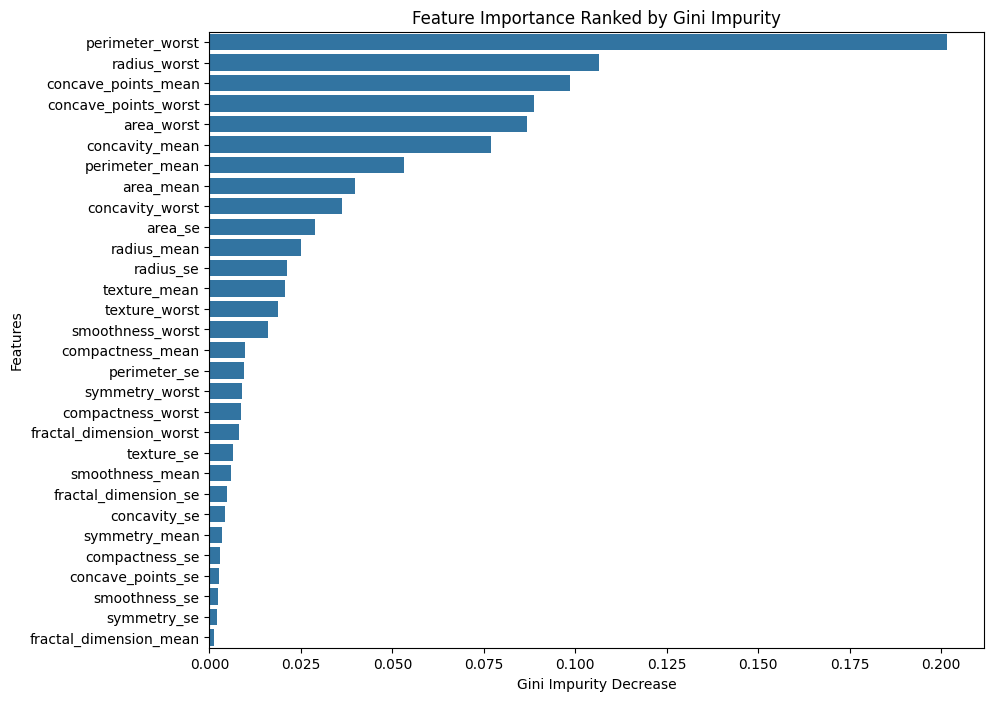

In [ ]:
#feature selection using Random forest
train_data = train_data.drop('PID', axis=1)
columns_to_check_cont = train_data.columns[0:30]

# RF feature importance
# Extract features and target variable
columns_to_check_cont = train_data.columns[0:30]
X = train_data[columns_to_check_cont]
y = train_data['Malignant']

# Initialize RandomForest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)

# 5-Fold Cross-Validation using AUC as the scoring metric
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cross_val_scores = cross_val_score(rf, X, y, cv=cv, scoring='roc_auc')

# Fit the Random Forest model to get feature importances
rf.fit(X, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': columns_to_check_cont, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Cross-Validation AUC Scores:", cross_val_scores)
print("Average AUC Score:", np.mean(cross_val_scores))
print("\nFeature Importances:\n", feature_importance_df)

# Sort the DataFrame by importance in ascending order for the plot
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)

plt.title('Feature Importance Ranked by Gini Impurity')
plt.xlabel('Gini Impurity Decrease')
plt.ylabel('Features')

plt.show()

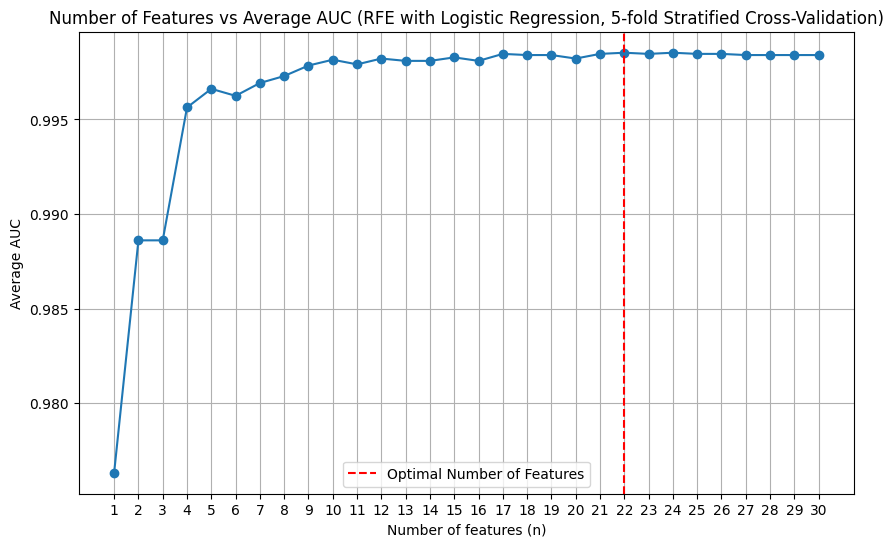

Index(['area_mean', 'concavity_mean', 'concave_points_mean', 'area_se',
       'compactness_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
       'area_worst', 'smoothness_worst', 'concave_points_worst',
       'symmetry_worst'],
      dtype='object')


In [ ]:
#feature selection using RFE
# RFE feature selection
X = train_data[columns_to_check_cont]
y = train_data['Malignant']

# Initialize Logistic Regression
logistic_model = LogisticRegression()

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5)

# Initialize RFE with Logistic Regression
rfe = RFE(estimator=logistic_model)

# Lists to store results
num_features_list = []
auc_list = []

# Iterate over different numbers of features
for num_features in range(1, len(X.columns) + 1):
    rfe.n_features_to_select = num_features

    # Initialize list for cross-validation results
    cv_auc_list = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        rfe.fit(X_train, y_train)
        RFE_selected_features = X_train.columns[rfe.support_]

        # Train and evaluate the model on the test set
        logistic_model.fit(X_train[RFE_selected_features], y_train)
        y_pred = logistic_model.predict_proba(X_test[RFE_selected_features])[:, 1]

        # Calculate AUC
        auc_score = roc_auc_score(y_test, y_pred)
        cv_auc_list.append(auc_score)

    # Calculate average AUC across folds
    avg_auc = np.mean(cv_auc_list)

    # Append results to lists
    num_features_list.append(num_features)
    auc_list.append(avg_auc)

# Find the index corresponding to the maximum AUC
optimal_num_features_index = np.argmax(auc_list)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_features_list, auc_list, marker='o')
plt.title('Number of Features vs Average AUC (RFE with Logistic Regression, 5-fold Stratified Cross-Validation)')
plt.xlabel('Number of features (n)')
plt.ylabel('Average AUC')

# Set x-axis ticks at the interval of 1 integer
plt.xticks(range(min(num_features_list), max(num_features_list) + 1, 1))

plt.axvline(num_features_list[optimal_num_features_index], linestyle='--', color='red', label='Optimal Number of Features')
plt.legend()
plt.grid(True)
plt.show()

# # Set the optimal number of features (automated)
# optimal_num_features = num_features_list[optimal_num_features_index]

# Set the optimal number of features (to manual set features)
optimal_num_features = 12

# Initialize RFE with the optimal number of features
rfe.n_features_to_select = optimal_num_features
rfe.fit(X, y)

# Get the selected features
RFE_selected_features_withHighAUC = X.columns[rfe.support_]
print(RFE_selected_features_withHighAUC)


Best Alpha: 0.0016297508346206436
Best Rho (l1_ratio): 1.0
Selected Features: Index(['radius_mean', 'concavity_mean', 'fractal_dimension_mean', 'radius_se',
       'texture_se', 'area_se', 'texture_worst', 'smoothness_worst',
       'concave_points_worst', 'fractal_dimension_worst'],
      dtype='object')


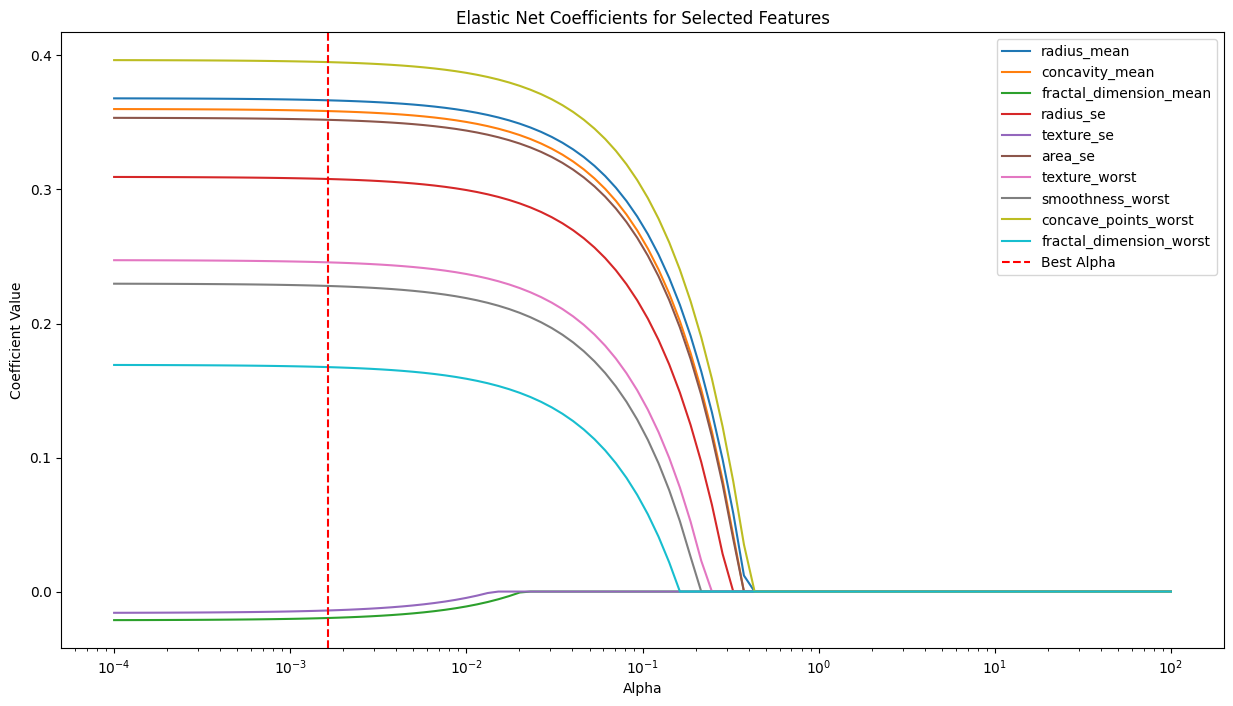

In [ ]:
# feature selection (Elastic Net)
# Elastic Net feature selection
target_variable = 'Malignant'
X_train = train_data.drop(['Malignant'], axis=1)
y_train = train_data[target_variable]

# Split the training data into train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=43)

# Create Elastic Net model with cross-validation
elastic_net = ElasticNetCV(
    l1_ratio=np.linspace(0.01, 1.0, 100),
    alphas=np.logspace(-4, 2, 100),
    cv=5,
    random_state=42,
    max_iter=10000  # Increase max_iter if needed
)

# Fit the Elastic Net model to the training data
elastic_net.fit(X_train_split, y_train_split)

# Get the best alpha and rho
best_alpha = elastic_net.alpha_
best_rho = elastic_net.l1_ratio_

# Print the best alpha and rho
print(f'Best Alpha: {best_alpha}')
print(f'Best Rho (l1_ratio): {best_rho}')

# Predict the probability of positive class for validation set
y_val_pred_proba = elastic_net.predict(X_val_split)

# Train Elastic Net model with best parameters
final_elastic_net = ElasticNetCV(
    l1_ratio=best_rho,
    alphas=[best_alpha],
    cv=5,
    random_state=42,
    max_iter=10000
)

final_elastic_net.fit(X_train, y_train)

# Select features based on the best Elastic Net model
feature_selector = SelectFromModel(final_elastic_net, threshold='mean')
X_train_selected = feature_selector.fit_transform(X_train, y_train)

# Get the selected feature names
EN_selected_feature = X_train.columns[feature_selector.get_support()]

# Print the selected feature names
print(f'Selected Features: {EN_selected_feature}')

# Store coefficients in a DataFrame
EN_selected_feature_coef = pd.DataFrame(index=elastic_net.alphas_)

# Plot the coefficients of the selected features with respect to alpha values
plt.figure(figsize=(15, 8))

# Iterate over the selected features
for feature in EN_selected_feature:
    # Extract the coefficients using a single feature at a time
    coef_values = []
    for alpha in elastic_net.alphas_:
        elastic_net_per_alpha = ElasticNet(alpha=alpha, l1_ratio=best_rho, max_iter=10000)
        elastic_net_per_alpha.fit(X_train[[feature]], y_train)
        coef_values.append(elastic_net_per_alpha.coef_[0])

    # Plot the coefficients against the alpha values
    plt.plot(elastic_net.alphas_, coef_values, label=feature)

    # Store coefficients in the DataFrame
    EN_selected_feature_coef[feature] = coef_values

# Plot a vertical line at the position of the best alpha
plt.axvline(x=best_alpha, color='r', linestyle='--', label='Best Alpha')

# Customize the plot
plt.xscale('log')  # Use log scale for better visualization
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.title('Elastic Net Coefficients for Selected Features')
plt.legend()
plt.show()

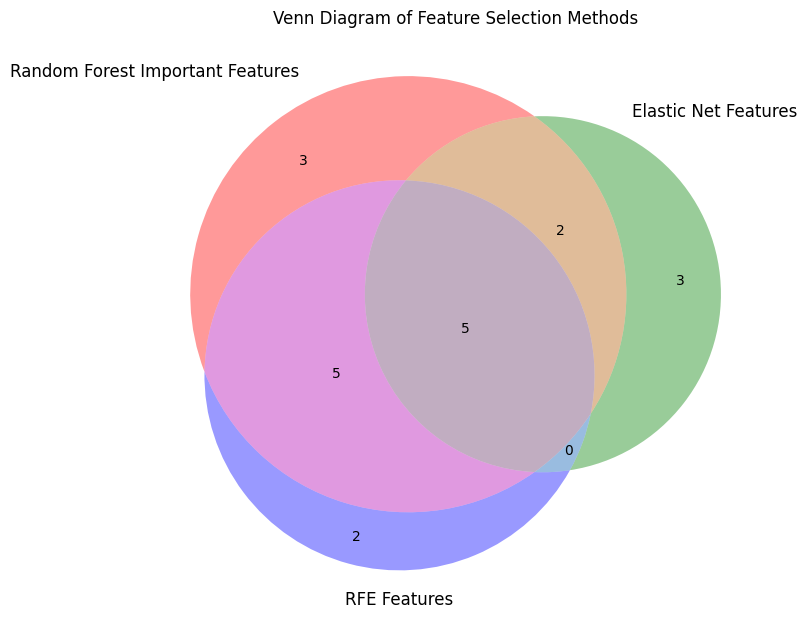

Common features across all three methods: {'texture_worst', 'smoothness_worst', 'area_se', 'concavity_mean', 'concave_points_worst'}
Shared between Random Forest and Elastic Net: {'radius_mean', 'radius_se'}
Shared between Random Forest and RFE: {'perimeter_worst', 'area_mean', 'concave_points_mean', 'area_worst', 'radius_worst'}
Shared between Elastic Net and RFE: set()


In [ ]:
# venn diagram for features
# Venn diagram for feature selection
# Sample lists of features.
RF_selected_features = [
    "perimeter_worst",
    "radius_worst",
    "concave_points_mean",
    "concave_points_worst",
    "area_worst",
    "concavity_mean",
    "perimeter_mean",
    "area_mean",
    "concavity_worst",
    "area_se",
    "radius_mean",
    "radius_se",
    "texture_mean",
    "texture_worst",
    "smoothness_worst"
]

EN_selected_features = ['radius_mean', 'concavity_mean', 'fractal-dimension_mean', 'radius_se', 'texture_se', 'area_se', 'texture_worst', 'smoothness_worst', 'concave_points_worst', 'fractal_dimension_worst']
RFE_selected_features_withHighAUC = ['area_mean', 'concavity_mean', 'concave_points_mean', 'area_se',
       'compactness_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
       'area_worst', 'smoothness_worst', 'concave_points_worst',
       'symmetry_worst']

# Create a Venn diagram
plt.figure(figsize=(8, 8))
venn3([set(RF_selected_features), set(EN_selected_features), set(RFE_selected_features_withHighAUC)],
      set_labels=('Random Forest Important Features', 'Elastic Net Features', 'RFE Features'))
plt.title("Venn Diagram of Feature Selection Methods")
plt.show()

# Convert lists to sets
RF_set = set(RF_selected_features)
EN_set = set(EN_selected_features)
RFE_set = set(RFE_selected_features_withHighAUC)

# Find
common_features = RF_set.intersection(EN_set, RFE_set)
print("Common features across all three methods:", common_features)


# Find unique and shared features
shared_RF_EN = RF_set.intersection(EN_set) - RFE_set
shared_RF_RFE = RF_set.intersection(RFE_set) - EN_set
shared_EN_RFE = EN_set.intersection(RFE_set) - RF_set

# Print results
print("Shared between Random Forest and Elastic Net:", shared_RF_EN)
print("Shared between Random Forest and RFE:", shared_RF_RFE)
print("Shared between Elastic Net and RFE:", shared_EN_RFE)